
# MNIST — Passive Phase: Feature Extraction + Optimal Transport (OT)

Extracts a **feature space** for MNIST images and computes **OT-based distances** between datasets:
- **train** (real training set),
- **test** (real test set),
- **gen** (generated set; optional for now, add later).



## 0) Environment



In [1]:
#@title installs

import sys, subprocess, importlib

def pip_install(pkg, import_name=None):
    import_name = import_name or pkg
    try:
        importlib.import_module(import_name)
        print(f"✅ {pkg} already installed.")
    except ImportError:
        print(f"📦 Installing {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        print(f"✅ {pkg} installed successfully.")

# Core
pip_install("torch")
pip_install("torchvision")
pip_install("numpy")
pip_install("matplotlib")

# OT libraries
pip_install("POT", "ot")      # Python Optimal Transport (import as `ot`)
pip_install("geomloss")

print("🎉 Environment ready.")


✅ torch already installed.
✅ torchvision already installed.
✅ numpy already installed.
✅ matplotlib already installed.
✅ POT already installed.
✅ geomloss already installed.
🎉 Environment ready.



## 1) Data — MNIST loaders (train/test/gen)


In [ ]:
#@title Helper functions

# --- Imports ---
import torch, random, os, numpy as np
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from pathlib import Path

# --- Config ---
train_path, test_path, gen_path = "./data/train_mnist.pt", "./data/test_mnist.pt", "./data/gen_mnist.pt"  # or None
batch_size, gen_k = 512, 2000
device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Seed ---
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
set_seed()

# --- Transform for TorchVision fallback ---
T28 = transforms.Compose([transforms.Grayscale(1), transforms.Resize((28,28)), transforms.ToTensor()])

# --- Loader for .pt (expects dict with 'x' and optional 'y', or tensor x) ---
def load_pt(path):
    obj = torch.load(path, map_location="cpu")
    feat, labels = (obj["x"], obj.get("y")) if isinstance(obj, dict) else (obj, None)
    if feat.ndim == 3: feat = feat.unsqueeze(1)
    feat = feat.float() / (255.0 if feat.max() > 1 else 1)
    labels = torch.full((len(feat),), -1, dtype=torch.long) if labels is None else torch.as_tensor(labels).long()
    print(f"[Loaded {path}] -> features:{tuple(feat.shape)} labels:{tuple(labels.shape)} range=({feat.min():.1f},{feat.max():.1f})")
    return TensorDataset(feat.contiguous(), labels.contiguous())

# --- Builders ---
def build(path, train: bool, name="train"):
    if path and Path(path).exists():
        return load_pt(path)
    print(f"[Downloading TorchVision {name}]")
    return datasets.MNIST("./data", train=train, download=True, transform=T28)

def take_first_k(ds, k: int) -> TensorDataset:
    xs, ys = [], []
    loader = DataLoader(ds, batch_size=min(4096, k), shuffle=False)
    cnt = 0
    for xb, yb in loader:
        xs.append(xb); ys.append(yb)
        cnt += len(xb)
        if cnt >= k: break
    feat = torch.cat(xs, 0)[:k]
    labels = torch.cat(ys, 0)[:k].long()
    return TensorDataset(feat, labels)

def build_gen(path, test_ds, k: int, name="gen"):
    if path and Path(path).exists():
        return load_pt(path)
    print(f"[No gen file] -> building '{name}' from test (first {k})")
    # If test_ds already a TensorDataset, just slice:
    if isinstance(test_ds, TensorDataset):
        feat, labels = test_ds.tensors
        feat, labels = feat[:k], labels[:k].long()
        ds = TensorDataset(feat, labels)
    else:
        ds = take_first_k(test_ds, k)
    print(f"[Built gen] features:{tuple(ds.tensors[0].shape)} labels:{tuple(ds.tensors[1].shape)}")
    return ds


In [5]:
#@title Load from `pt` files
train_ds = build(train_path, True, "train")
test_ds  = build(test_path,  False, "test")
gen_ds   = build_gen(gen_path, test_ds, gen_k, "gen")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  pin_memory=(device=="cuda"))
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, pin_memory=(device=="cuda"))
gen_loader   = DataLoader(gen_ds,   batch_size=batch_size, shuffle=False, pin_memory=(device=="cuda"))

# --- Quick summary ---
print(f"\n[Summary] Train={len(train_ds)}  Test={len(test_ds)}  Gen={len(gen_ds)}  Batch={batch_size}")
xb, yb = next(iter(train_loader))
print(f"[One train batch] features:{tuple(xb.shape)} labels:{tuple(yb.shape)} dtype={xb.dtype} device={xb.device}")
print("Sample labels:", yb[:10].tolist())


[Loaded ./data/train_mnist.pt] -> features:(54912, 1, 28, 28) labels:(54912,) range=(-1.0,1.0)
[Loaded ./data/test_mnist.pt] -> features:(10000, 1, 28, 28) labels:(10000,) range=(-1.0,1.0)
[Loaded ./data/gen_mnist.pt] -> features:(5000, 1, 28, 28) labels:(5000,) range=(0.0,1.0)

[Summary] Train=54912  Test=10000  Gen=5000  Batch=512
[One train batch] features:(512, 1, 28, 28) labels:(512,) dtype=torch.float32 device=cpu
Sample labels: [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]



## 2) Feature extractor — SimpleMNISTFeatureNet

A compact CNN encoder sized to MNIST complexity, returning both logits and a **128-D feature** vector.


In [9]:
#@title SimpleMNISTFeatureNet

import torch.nn as nn
import torch.nn.functional as F
import torch

class SimpleMNISTFeatureNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.fc_feat = nn.Linear(64 * 5 * 5, 128)
        self.fc_out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        feat = F.relu(self.fc_feat(x))
        out = self.fc_out(feat)
        return out, feat

model = SimpleMNISTFeatureNet().to(device)
print("Parameters (k):", sum(p.numel() for p in model.parameters())/1e3)


Parameters (k): 225.034



## 3) Extract features for each set

Generates a matrix `features` of shape `(N, D)` and optional `labels` per set. We also **subsample per class** for fair OT comparisons and speed.


In [10]:
# === Config (replaces cfg) ===
batch_size = 512
device = "cuda" if torch.cuda.is_available() else "cpu"
ot_samples_per_class = 2000

# === DataLoaders without multiprocessing workers ===
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=False)
gen_loader   = DataLoader(gen_ds,   batch_size=batch_size, shuffle=False,
                          num_workers=0, pin_memory=False) if (gen_ds is not None) else None

# === Feature extraction ===
import torch, numpy as np

@torch.no_grad()
def extract_features(model, loader, device="cpu"):
    model.eval()
    feats, labels = [], []
    for batch in loader:
        if isinstance(batch, (list, tuple)) and len(batch) == 2:
            x, y = batch
        elif isinstance(batch, dict):
            x, y = batch.get("x"), batch.get("y", -1)
        else:
            x, y = batch, -1

        x = x.to(device)
        logits, feat = model(x)
        feats.append(feat.cpu())
        if not torch.is_tensor(y):
            y = torch.as_tensor(y)
        labels.append(y.clone().cpu())

    feats = torch.cat(feats, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy() if len(labels) > 0 else None
    return feats, labels

# === Balanced subsampling ===
def balanced_subsample(feats: np.ndarray, labels: np.ndarray | None, per_class: int = 2000) -> np.ndarray:
    if labels is None or (np.asarray(labels) < 0).all():
        max_n = min(per_class * 10, len(feats))  # assume 10 classes
        idx = np.random.choice(len(feats), size=max_n, replace=False)
        return feats[idx]
    sel = []
    for c in range(10):
        idx = np.where(labels == c)[0]
        if len(idx) == 0: continue
        take = min(per_class, len(idx))
        sel.append(np.random.choice(idx, size=take, replace=False))
    sel = np.concatenate(sel, axis=0)
    return feats[sel]

# === Run extraction and subsampling ===
train_feats, train_labels = extract_features(model, train_loader, device=device)
test_feats,  test_labels  = extract_features(model, test_loader,  device=device)
gen_feats,   gen_labels   = (extract_features(model, gen_loader, device=device)
                             if gen_loader is not None else (None, None))

train_feats_sub = balanced_subsample(train_feats, train_labels, per_class=ot_samples_per_class)
test_feats_sub  = balanced_subsample(test_feats,  test_labels,  per_class=ot_samples_per_class)
gen_feats_sub   = (balanced_subsample(gen_feats, gen_labels, per_class=ot_samples_per_class)
                   if gen_feats is not None else None)

print("Shapes (full):   ", train_feats.shape, test_feats.shape, (None if gen_feats is None else gen_feats.shape))
print("Shapes (sampled):", train_feats_sub.shape, test_feats_sub.shape, (None if gen_feats_sub is None else gen_feats_sub.shape))


Shapes (full):    (54912, 128) (10000, 128) (5000, 128)
Shapes (sampled): (20000, 128) (10000, 128) (5000, 128)



## 4) OT distances



In [11]:
!pip install POT

In [12]:
#@title compute all pairs

import numpy as np
import ot

# ---- Helpers ----
def _safe_max(C: np.ndarray) -> float:
    """Return a safe positive max for scaling."""
    cmax = np.max(C)
    return 1.0 if (not np.isfinite(cmax) or cmax <= 0) else float(cmax)

def sinkhorn_official_plan(
    x: np.ndarray,
    y: np.ndarray,
    reg: float = 0.1,
    nit: int = 100,
    metric: str = "euclidean",
    stopThr: float = 1e-9,
):
    """
    Implements the 'official' Sinkhorn algorithm with logging.
    """
    print("\n=== Starting Sinkhorn Official Plan ===")
    print(f"Shapes: x={x.shape}, y={y.shape}")
    print(f"reg={reg}, iterations={nit}\n")

    # uniform marginals
    n, m = len(x), len(y)
    a = ot.utils.unif(n).astype(np.float64)
    b = ot.utils.unif(m).astype(np.float64)

    # cost matrix
    C = ot.dist(x.astype(np.float64), y.astype(np.float64), metric=metric)
    cmax = _safe_max(C)
    M = C / cmax
    print(f"Max cost (cmax): {cmax:.4f}")
    print(f"Scaled cost matrix M.shape={M.shape}")

    # --- manual algorithm (u, v) ---
    K = np.exp(-M / reg)
    print("Initialized kernel K from exp(-M/reg).")

    u = np.ones_like(a)
    for it in range(1, nit + 1):
        v = b / (K.T @ u)
        u = a / (K @ v)
        if it % (nit // 5) == 0 or it == nit:
            print(f"Iteration {it}/{nit}: u[0]={u[0]:.4f}, v[0]={v[0]:.4f}")

    T_algo = (u[:, None] * K) * v[None, :]
    print("Manual transport plan computed.")

    # --- POT sinkhorn with the same M and reg ---
    print("\nRunning ot.sinkhorn (POT)...")
    T_pot = ot.sinkhorn(a, b, M, reg=reg, numItermax=nit, stopThr=stopThr)
    print("POT transport plan computed.")

    # --- difference and costs in original C units ---
    diff_l2 = float(np.sum((T_algo - T_pot) ** 2))
    cost_algo = float(np.sum(M * T_algo) * cmax)
    cost_pot  = float(np.sum(M * T_pot)  * cmax)

    print("\n=== Results ===")
    print(f"L2 difference between manual and POT plans: {diff_l2:.4e}")
    print(f"Manual OT cost (original units): {cost_algo:.4f}")
    print(f"POT OT cost    (original units): {cost_pot:.4f}")
    print("=============================\n")

    return T_algo, T_pot, diff_l2, cost_algo, cost_pot


def compute_all_pairs_official(train_sub, test_sub, gen_sub, reg=0.1, nit=100):
    """
    Compute and print results for (train,test), (train,gen), (test,gen).
    """
    out = {}

    print(">>> Train vs Test")
    T_algo, T_pot, diff, cost_algo, cost_pot = sinkhorn_official_plan(
        train_sub, test_sub, reg=reg, nit=nit
    )
    out["train_test_diff"] = diff
    out["train_test_cost_algo"] = cost_algo
    out["train_test_cost_pot"] = cost_pot

    if gen_sub is not None:
        print(">>> Train vs Gen")
        T_algo, T_pot, diff, cost_algo, cost_pot = sinkhorn_official_plan(
            train_sub, gen_sub, reg=reg, nit=nit
        )
        out["train_gen_diff"] = diff
        out["train_gen_cost_algo"] = cost_algo
        out["train_gen_cost_pot"] = cost_pot

        print(">>> Test vs Gen")
        T_algo, T_pot, diff, cost_algo, cost_pot = sinkhorn_official_plan(
            test_sub, gen_sub, reg=reg, nit=nit
        )
        out["test_gen_diff"] = diff
        out["test_gen_cost_algo"] = cost_algo
        out["test_gen_cost_pot"] = cost_pot

    print("\n=== Final Summary ===")
    for k, v in out.items():
        print(f"{k:25s}: {v:.4f}")
    print("======================\n")

    return out



results = compute_all_pairs_official(train_feats_sub, test_feats_sub, gen_feats_sub, reg=0.1, nit=100)
print(results)


>>> Train vs Test

=== Starting Sinkhorn Official Plan ===
Shapes: x=(20000, 128), y=(10000, 128)
reg=0.1, iterations=100

Max cost (cmax): 0.9418
Scaled cost matrix M.shape=(20000, 10000)
Initialized kernel K from exp(-M/reg).
Iteration 20/100: u[0]=0.8971, v[0]=0.0000
Iteration 40/100: u[0]=0.8971, v[0]=0.0000
Iteration 60/100: u[0]=0.8971, v[0]=0.0000
Iteration 80/100: u[0]=0.8971, v[0]=0.0000
Iteration 100/100: u[0]=0.8971, v[0]=0.0000
Manual transport plan computed.

Running ot.sinkhorn (POT)...
POT transport plan computed.

=== Results ===
L2 difference between manual and POT plans: 1.5987e-28
Manual OT cost (original units): 0.4752
POT OT cost    (original units): 0.4752

>>> Train vs Gen

=== Starting Sinkhorn Official Plan ===
Shapes: x=(20000, 128), y=(5000, 128)
reg=0.1, iterations=100

Max cost (cmax): 1.2050
Scaled cost matrix M.shape=(20000, 5000)
Initialized kernel K from exp(-M/reg).
Iteration 20/100: u[0]=0.9687, v[0]=0.0000
Iteration 40/100: u[0]=0.9687, v[0]=0.0000
I


## 5) Visualizations

- **Bar plot** of OT distances across pairs and methods.
- **t-SNE/UMAP (optional)** on features to visualize distributions per class.


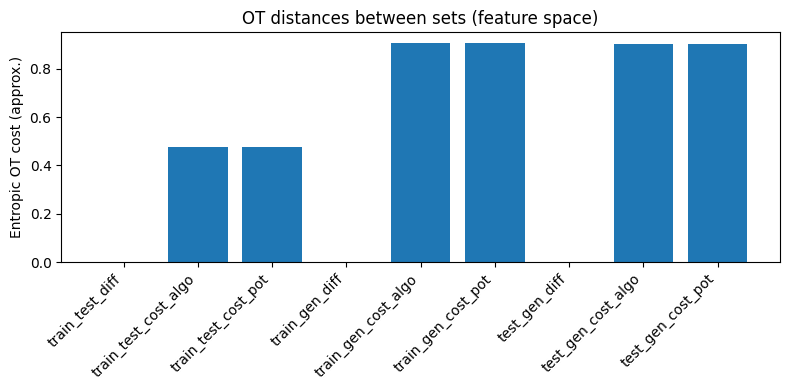

In [13]:

import matplotlib.pyplot as plt

labels = list(results.keys())
vals = [results[k] for k in labels]

plt.figure(figsize=(8, 4))
plt.bar(range(len(vals)), vals)  # single plot, no explicit colors/styles
plt.xticks(range(len(vals)), labels, rotation=45, ha='right')
plt.ylabel("Entropic OT cost (approx.)")
plt.title("OT distances between sets (feature space)")
plt.tight_layout()
plt.show()


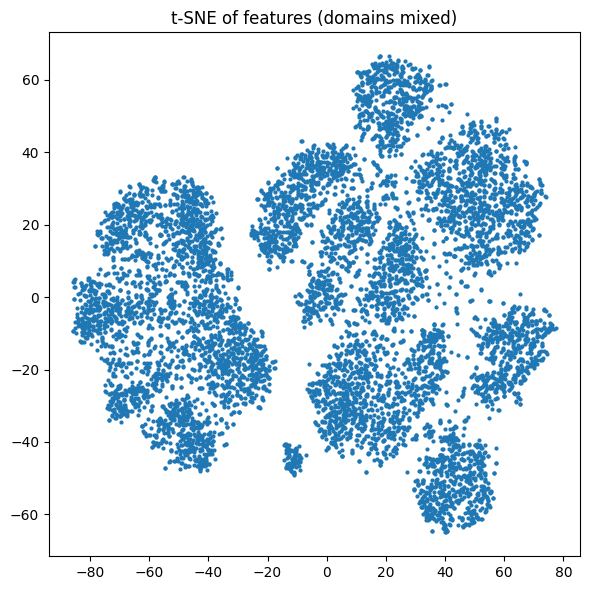

In [14]:
#@title Optional: t-SNE visualization (quick view of feature space). Disable if scikit-learn missing.

try:
    from sklearn.manifold import TSNE
    import numpy as np
    import matplotlib.pyplot as plt

    def sample_for_tsne(feats, labels, per_class=300):
        idxs = []
        if labels is not None and (labels >= 0).any():
            for c in range(10):
                cand = np.where(labels == c)[0]
                if len(cand) == 0:
                    continue
                take = min(per_class, len(cand))
                idxs.append(np.random.choice(cand, size=take, replace=False))
            if idxs:
                idxs = np.concatenate(idxs)
            else:
                idxs = np.random.choice(len(feats), size=min(3000, len(feats)), replace=False)
        else:
            idxs = np.random.choice(len(feats), size=min(3000, len(feats)), replace=False)
        return feats[idxs], (labels[idxs] if labels is not None and (labels >= 0).any() else -np.ones(len(idxs), dtype=int))

    sets = [("train", train_feats, train_labels), ("test", test_feats, test_labels)]
    if gen_feats is not None:
        sets.append(("gen", gen_feats, gen_labels))

    all_feat, all_lab, all_dom = [], [], []
    for name, feats, labels in sets:
        f, l = sample_for_tsne(feats, labels, per_class=200)
        all_feat.append(f)
        all_lab.append(l)
        all_dom += [name] * len(f)
    X = np.concatenate(all_feat, axis=0)
    Y = np.concatenate(all_lab, axis=0)

    X2 = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca').fit_transform(X)

    plt.figure(figsize=(6,6))
    plt.scatter(X2[:,0], X2[:,1], s=4)  # single plot, default colors
    plt.title("t-SNE of features (domains mixed)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("t-SNE visualization skipped:", e)



## 6) Sensitivity experiments (scaffold)

Use these helpers to **manipulate** distributions (e.g., drop classes to degrade recall, add near-duplicates to stress precision) and observe how OT responds.


In [16]:
import numpy as np
from typing import List, Tuple, Optional

def drop_classes(feats: np.ndarray, labels: np.ndarray, drop_list: List[int]) -> Tuple[np.ndarray, np.ndarray]:
    """Remove all samples whose label is in drop_list."""
    drop_set = set(drop_list)
    keep = ~np.isin(labels, list(drop_set))
    return feats[keep], labels[keep]

def duplicate_samples(feats: np.ndarray, labels: Optional[np.ndarray] = None, times: int = 2):
    """Repeat samples (and labels if provided) along the first axis."""
    f2 = np.repeat(feats, times, axis=0)
    if labels is None:
        return f2
    l2 = np.repeat(labels, times, axis=0)
    return f2, l2

# --- Local config (no cfg) ---
sinkhorn_reg = 0.05  # <- was cfg.sinkhorn_reg

# --- Use it ---
degraded_feats, degraded_labels = drop_classes(train_feats, train_labels, drop_list=[8, 9])
# If you also want to inflate the dataset:
# degraded_feats, degraded_labels = duplicate_samples(degraded_feats, degraded_labels, times=2)

# Guard if gen set is optional
gen_for_ot = gen_feats_sub if gen_feats_sub is not None else degraded_feats[:1000]

# Call your existing function (assumed defined earlier)
ot_drop = compute_all_pairs_official(
    degraded_feats,          # source/train features (after dropping)
    test_feats_sub,          # target/test features
    gen_for_ot,              # optional "gen" pool (or any third set)
    reg=sinkhorn_reg
)

print("After drop:", degraded_feats.shape, degraded_labels.shape)
print("OT (with dropped classes):", ot_drop)


>>> Train vs Test

=== Starting Sinkhorn Official Plan ===
Shapes: x=(54912, 128), y=(10000, 128)
reg=0.05, iterations=100

Max cost (cmax): 0.9418
Scaled cost matrix M.shape=(54912, 10000)
Initialized kernel K from exp(-M/reg).
Iteration 20/100: u[0]=1.2211, v[0]=0.0000
Iteration 40/100: u[0]=1.2211, v[0]=0.0000
Iteration 60/100: u[0]=1.2211, v[0]=0.0000
Iteration 80/100: u[0]=1.2211, v[0]=0.0000
Iteration 100/100: u[0]=1.2211, v[0]=0.0000
Manual transport plan computed.

Running ot.sinkhorn (POT)...
POT transport plan computed.

=== Results ===
L2 difference between manual and POT plans: 5.9677e-23
Manual OT cost (original units): 0.4213
POT OT cost    (original units): 0.4213

>>> Train vs Gen

=== Starting Sinkhorn Official Plan ===
Shapes: x=(54912, 128), y=(5000, 128)
reg=0.05, iterations=100

Max cost (cmax): 1.2632
Scaled cost matrix M.shape=(54912, 5000)
Initialized kernel K from exp(-M/reg).
Iteration 20/100: u[0]=1.7984, v[0]=0.0022
Iteration 40/100: u[0]=1.7984, v[0]=0.0022